# Project - First Requirement

### Include packages.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm    # Just to plot distribution of valuations

### The first thing to do is to code the environment.

In [28]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [29]:
class PricingEnvironmentSingleProduct:
    def __init__(self, valuations, cost):
        self.valuations = valuations
        self.cost = cost

    def round(self, p_t):
        num_of_sales = np.sum(self.valuations >= p_t)       # Count how many customers are willing to pay at least p_t
        reward = (p_t - self.cost) * num_of_sales           # Count the profit subtracting the cost from the price for each sale
        return num_of_sales, reward

### Now define the setting...

In [30]:
# --- Setting - Things that the seller needs to know --- #

min_p = 0                                   # Minimum price in euro
max_p = 5                                   # Maximum price in euro

T = 25000                                                           # Number of rounds
N = 1                                                               # Number of products
P = np.linspace(min_p, max_p, int((max_p - min_p) / 0.5) + 1)       # Prices from min_p to max_p inclusive, stepping by 0.5
B = 20000                                                           # Number of buyers

# --- Setting - Some stuff --- #

np.random.seed(30)
n_trials = 100                                                    # Number of trials to run for empirical regret results

# --- Setting - Things that the environment needs to know --- #

num_of_buyers = ( int ) ( B / T * 50 )                                          # Assuming I can sell on average B / T * 50 items per round
assert not num_of_buyers < 1, "Number of buyers must be greater than 0"         # Assert that the number of buyers is greater than 0
value = 3.00                                                                    # "Real value" of the product
cost = 2.00                                                                     # Cost of the product
assert cost < value, "Cost must be less than the value of the product"          # Assert that cost is less than value
valuations = np.random.normal(loc=value, scale=1.0, size=num_of_buyers)         # Generate random valuations around 3.50€

# --- Setting - Define the environment --- #

env = PricingEnvironmentSingleProduct(valuations=valuations, cost=cost)

### Expected demand and profit using theoretical expectations.

In [31]:
# In our setting, customer valuations are drawn from a normal distribution.
# Given this assumption, we can analytically compute the expected demand at each price p.
# It can be proven that the expected demand is given by: 

def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(num_of_buyers, value), scale=1.0))

# This results in a smooth probability-based estimation of demand for each price p,
# where the probability for a single customer to buy is the tail area of the normal distribution beyond p.

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_index = np.argmax(expected_profit_vector)
best_price = P[best_index]
best_profit = expected_profit_vector[best_index]

### Realized demand and profit based on sampled valuations.

In [32]:
# Here we show the demand curve after drawing the customers evaluations.

def realized_demand(valuations, p):
    return np.sum(valuations >= p)

realized_demand_vector = np.array([realized_demand(valuations, p) for p in P])
realized_profit_vector = (P - cost) * realized_demand_vector

best_realized_index = np.argmax(realized_profit_vector)
best_realized_price = P[best_realized_index]
best_realized_profit = realized_profit_vector[best_realized_index]

### Let us visualize our setting.

Max expected profit (theoretical): 20.0
...at price: 3.0
Max realized profit (empirical): 21.0
...at price: 3.5


/var/folders/zn/rf3j_pdd4_d02m04l2_1fjcw0000gn/T/ipykernel_25972/1912500450.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


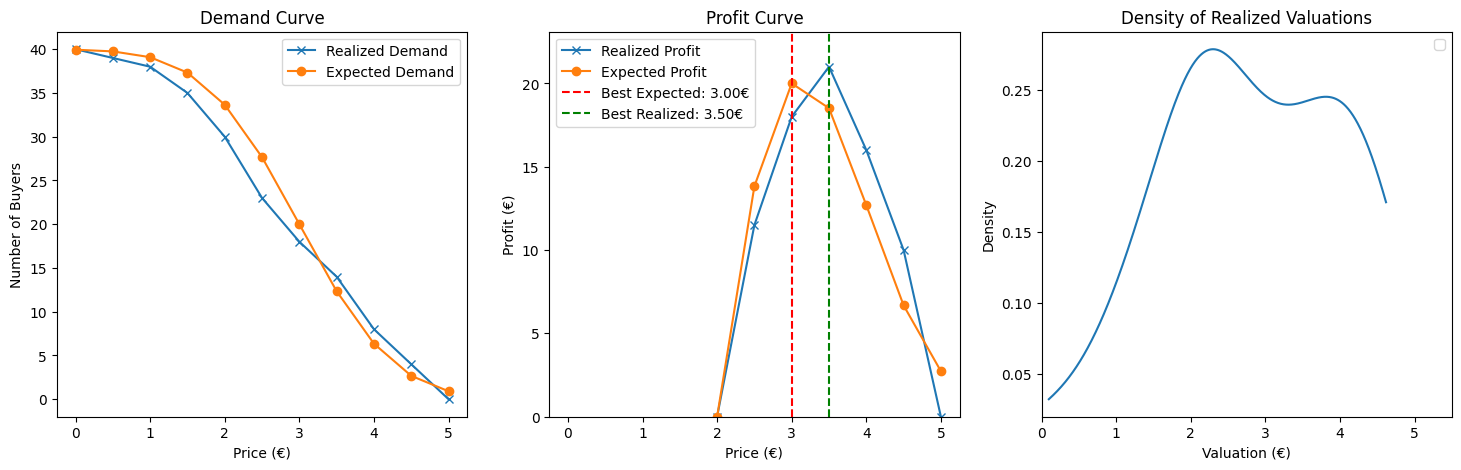

In [33]:
# --- Summary of Results ---

print("Max expected profit (theoretical):", round(best_profit, 2))
print("...at price:", round(best_price, 2))

print("Max realized profit (empirical):", round(best_realized_profit, 2))
print("...at price:", round(best_realized_price, 2))

# --- Plots: Expected vs Realized Demand and Profit ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Demand comparison
axs[0].plot(P, realized_demand_vector, label='Realized Demand', marker='x')
axs[0].plot(P, expected_demand_vector, label='Expected Demand', marker='o')
axs[0].set_title("Demand Curve")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Number of Buyers")
axs[0].legend()

# Profit comparison
axs[1].plot(P, realized_profit_vector, label='Realized Profit', marker='x')
axs[1].plot(P, expected_profit_vector, label='Expected Profit', marker='o')
axs[1].axvline(best_price, color='r', linestyle='--', label=f"Best Expected: {best_price:.2f}€")
axs[1].axvline(best_realized_price, color='g', linestyle='--', label=f"Best Realized: {best_realized_price:.2f}€")
axs[1].set_title("Profit Curve")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Profit (€)")
axs[1].legend()
# Automatically adjust y-axis to show just above the lowest observed positive profit
positive_profits = np.concatenate([expected_profit_vector, realized_profit_vector])
ymin = max(min(positive_profits[positive_profits > 0].min(), 0), 0)
ymax = positive_profits.max() * 1.1  # a bit of margin on top
axs[1].set_ylim(ymin, ymax)

# KDE of sampled valuations
x_vals = np.linspace(min(valuations), max(valuations), 1000)
axs[2].plot(x_vals, gaussian_kde(valuations)(x_vals))
axs[2].set_xlim(min_p, max_p*1.1)
axs[2].set_title("Density of Realized Valuations")
axs[2].set_xlabel("Valuation (€)")
axs[2].set_ylabel("Density")
axs[2].legend()

### How can I interact with this environment? We use Agents.

In [34]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

### Define the UCB1 Agent.

In [35]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.

class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K: # In the first K rounds, we sample each arm once
            self.a_t = self.t
        else:   
            ucbs = self.average_rewards + self.range * np.sqrt( 2 * np.log(self.T) / self.N_pulls )
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += ( r_t - self.average_rewards[self.a_t] ) / self.N_pulls[self.a_t]
        self.t += 1

### E.g. Instantaneous Regret - Single run.

In the following example (seed=30, at least 25k rounds), we show that analysing the regret over a single run might be meaningless, using the "a priori" clairvoyant assumptions. In a pricing scenario, it is crucial to carefully define what we mean by a "clairvoyant" benchmark, as different definitions can lead to significantly different interpretations of algorithmic performance. When using the "a priori" expected-optimal price — i.e., the price that maximizes expected profit under the assumed demand distribution — we implicitly assume that the seller does not know the exact valuations of arriving buyers; however, in a realized setting, where buyer valuations are drawn once and fixed throughout the episode, a truly clairvoyant seller would exploit this knowledge to set the price that maximizes profit given the actual observed valuations. 

In [36]:
R = (max(P)-cost) * num_of_buyers
K = len(P)

A priori expected best price (a priori clairvoyant): 3.0
A posteriori realized best price (a posteriori clairvoyant): 3.5


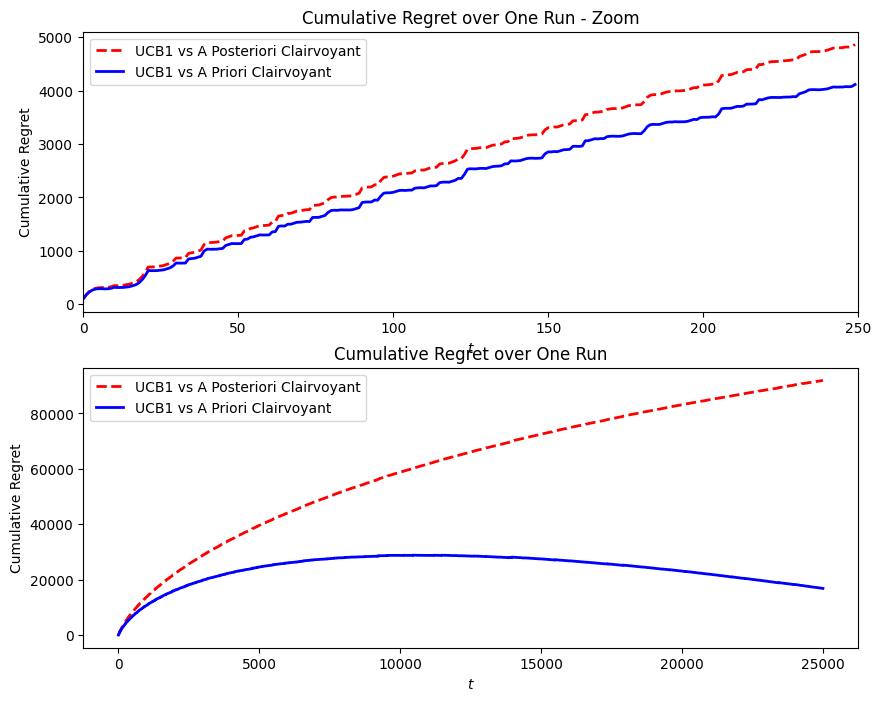

In [37]:
# --- Single run to compare realized rewards ---

# Compute clairvoyant rewards
clairvoyant_expected_rewards = np.array([env.round(P[best_index])[1] for _ in range(T)])
clairvoyant_realized_rewards = np.array([env.round(P[best_realized_index])[1] for _ in range(T)])

# Run UCB1
ucb_agent = UCB1Agent(K, T, range=R)
agent_rewards = np.array([])
pull_counts = np.zeros(K, dtype=int)  # <-- Track number of times each arm is pulled
for t in range(T):
    pi_t = ucb_agent.pull_arm()
    p_t = P[pi_t]
    d_t, r_t = env.round(p_t)
    ucb_agent.update(r_t)
    agent_rewards = np.append(agent_rewards, r_t)
    pull_counts[pi_t] += 1

# Compute most played price
most_played_action = np.argmax(pull_counts)
most_played_price = P[most_played_action]

# Compute realized regret
realized_regret = np.cumsum(clairvoyant_realized_rewards - agent_rewards)
expected_regret = np.cumsum(clairvoyant_expected_rewards - agent_rewards)

print("A priori expected best price (a priori clairvoyant):", round(best_price, 2))
print("A posteriori realized best price (a posteriori clairvoyant):", round(best_realized_price, 2))

# Plots
zoom_T = int(T * 0.01)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Zoom
ax1.plot(np.arange(zoom_T), realized_regret[:zoom_T], 'r--', linewidth=2, label='UCB1 vs A Posteriori Clairvoyant')
ax1.plot(np.arange(zoom_T), expected_regret[:zoom_T], 'b-', linewidth=2, label='UCB1 vs A Priori Clairvoyant')
ax1.set_xlim(0, zoom_T)
ax1.set_title(f'Cumulative Regret over One Run - Zoom')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Cumulative Regret')
ax1.legend()

# Full
ax2.plot(np.arange(T), realized_regret, 'r--', linewidth=2, label='UCB1 vs A Posteriori Clairvoyant')
ax2.plot(np.arange(T), expected_regret, 'b-', linewidth=2, label='UCB1 vs A Priori Clairvoyant')
ax2.set_title('Cumulative Regret over One Run')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Cumulative Regret')
ax2.legend()

### Let's see in which arms the algorithm spent more time.

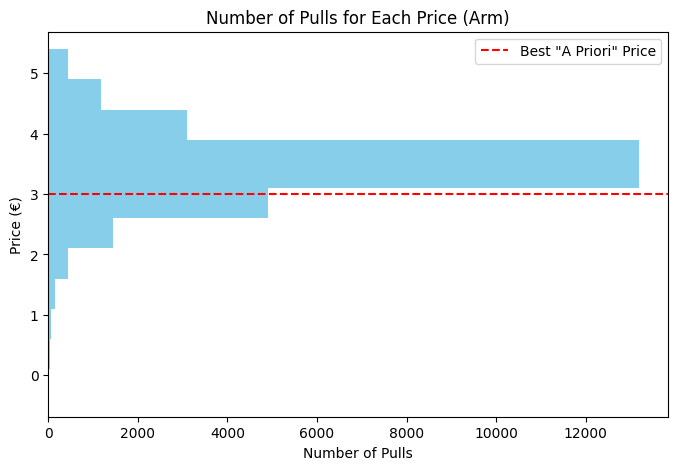

In [38]:
# --- UCB1 Agent ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_agent.N_pulls, color='skyblue')  # Usa i prezzi come y invece degli indici
plt.axhline(P[best_index], color='red', linestyle='--', label='Best "A Priori" Price')  # Linea orizzontale al prezzo migliore
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
plt.legend()

### Pseudo Regret - Estimation


Since it is very complex to compute the theoretical Expected Regret (nor Pseudo) at each round - due to the complex stochasticity in the choice of the action... We estimate it by computing it as the average cumulative regret per round, over many trials. To do this, we use the expected reward of both the clairvoyant and the agent actions, to reduce the variability of the estimation.

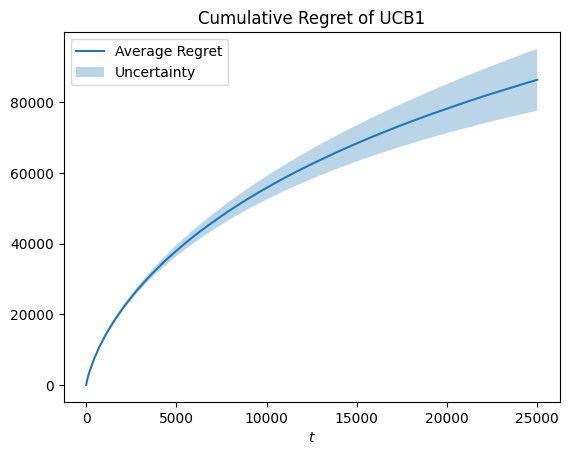

In [39]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_profit, T)

for seed in range(n_trials):
    np.random.seed(seed)
    
    # Create environment using new valuations
    valuations = np.random.normal(loc=value, scale=1.0, size=num_of_buyers)
    env = PricingEnvironmentSingleProduct(valuations, cost=cost)
    
    # Initialize
    ucb_agent = UCB1Agent(K, T, range=R)
    agent_rewards = np.array([])

    # Run UCB1 for T rounds
    for t in range(T):
        pi_t = ucb_agent.pull_arm()
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

# Compute average (and standard deviation) of regret
average_regret = np.array(regret_per_trial).mean(axis=0)
regret_sd = np.array(regret_per_trial).std(axis=0)

# Plot cumulative regret
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative Regret of UCB1')
plt.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, label='Uncertainty')
plt.xlabel('$t$')
plt.legend()